[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
<class 'numpy.ndarray'> (1000, 60)


[[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]
<class 'numpy.ndarray'> (1000, 2)


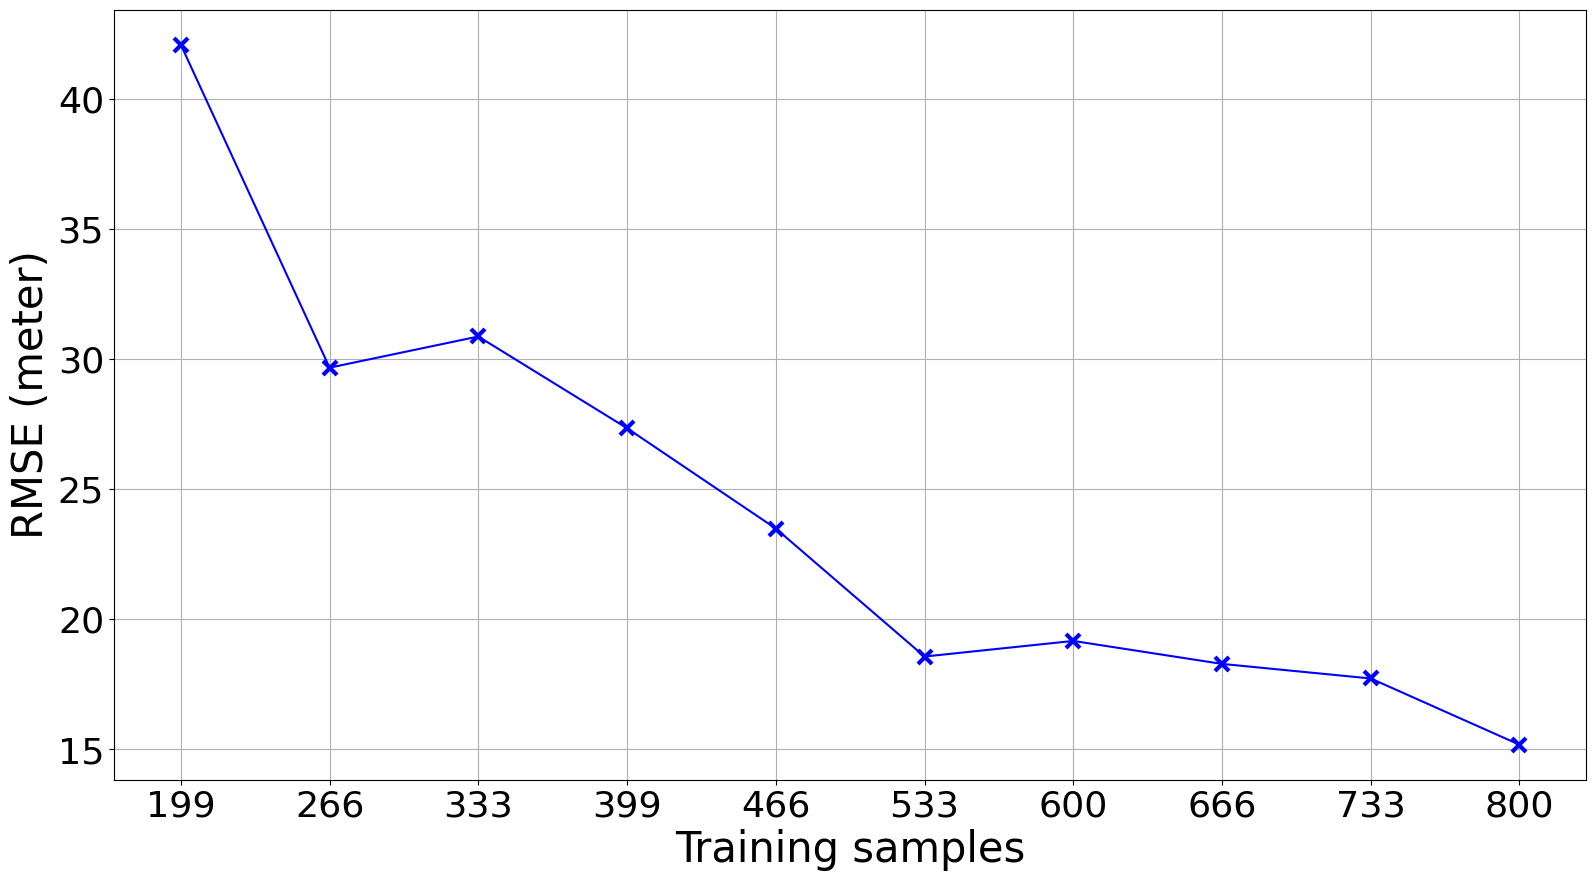

In [ ]:
'''
this script demonstrates the method to find true sources location from available false
positives due to the presense of multiple reflectors
'''

import numpy as np

def findpos(P,R):
    '''
    example P=[[1,2,3,4],[5,6,7,8]] 2 dimensional matrix, of which
    columns are (x,y) locations of the sensor
    '''
    from numpy.linalg import lstsq
    ref=0
    V = 2*(P.T - P[:,ref])
    y = (R[ref]**2 -  np.sum(P[:,ref]**2)-(R**2 -  np.sum(P**2,0)))
    V = np.delete(V,ref,0)
    y = np.delete(y,ref,0)
    xy_hat = lstsq(V,y,rcond=None)
    return xy_hat[0]

def getallcombs(a):
    '''
    user defined function to generate all combinations of rows
    for the given matrix input a
    '''
    import numpy as np

    # Get the number of columns
    options_per_column,num_columns = a.shape
    total_combinations = options_per_column ** num_columns

    # Create a loop to generate all possible combinations
    all_combs = []
    for i in range(total_combinations):
        # Initialize an empty list to store the current combination
        current_combination = []

        # Convert the current iteration value to a base `options_per_column` representation
        base_representation = []
        value = i
        for j in range(num_columns):
            base_representation.append(value % options_per_column)
            value //= options_per_column

        # Iterate over the base `options_per_column` representation and select the corresponding element
        for j in range(num_columns):
            choice = base_representation[j]
            current_combination.append(a[choice, j])

        all_combs.append(current_combination)
    return all_combs

def gen_multipath_loc(L,Pmax):
    tht_m = np.random.rand(L)*0.5*np.pi
    R_m = np.random.rand(L)*Pmax
    steer_m = np.vstack((np.cos(tht_m),np.sin(tht_m)))
    dist_source = np.sqrt(np.sum(((R_m*steer_m).T - R_source*steer)**2,1))
    cir_cen_nlos = R_m*steer_m
    return(tht_m,R_m,steer_m,dist_source)

def gen_sensor_loc(Nelements,Pmax_sensors):
    return(np.hstack(([[0],[0]],np.random.rand(2,Nelements-1)))*Pmax_sensors)

def gen_source_delay_gain(P,R_source,steer,A):
    c=343.0
    dR = np.sqrt(np.sum((P.T-R_source*steer)**2,1))
    tau_los = dR/c
    r_gain_los = A/np.sqrt(4*np.pi*dR**2)
    return(tau_los,r_gain_los)

def gen_multipath_delays_gain(L,Nelements,P,R_m,steer_m,A,dist_source):
    tau_nlos=np.zeros((L,Nelements),dtype=float)
    r_gain_nlos=np.zeros((L,Nelements),dtype=float)
    c=343.0
    for path in range(L):
        dR_m = np.sqrt(np.sum((P.T - R_m[path]*steer_m[:,path])**2,1))
        r_gain_nlos[path,:] = A/np.sqrt(4*np.pi*(dR_m+dist_source[path])**2)
        tau_nlos[path,:] = (dR_m+dist_source[path])/c
    del path
    return(tau_nlos,r_gain_nlos)

def combine_delay_gain(tau_los,tau_nlos,r_gain_los,r_gain_nlos,nstd,groups):
    tau_rec = [[list(tau_los[groups[group]]+(nstd*np.sqrt(12)*(np.random.rand(4)-0.5)))] for group in range(K)]
    r_gain = [[list(r_gain_los[groups[group]])] for group in range(K)]
    for group in range(K):
        temp_t = tau_nlos[:,groups[group]]
        temp_g = r_gain_nlos[:,groups[group]]
        t_rows = temp_t[~~group_sel[:,group].astype('bool'),:].shape[0]
        for nrow in range(t_rows):
            tau_rec[group].append(list(temp_t[nrow,:]+(nstd*np.sqrt(12)*(np.random.rand(4)-0.5))))
            r_gain[group].append(list(temp_g[nrow,:]))
    del nrow
    del group
    return(tau_rec,r_gain)


#### general parameters ###
c=343.0                     # speed of sound in air
nvardB=-50.0                # noise power (db)
nstd = 10**(nvardB/20)      # noise standard deviation (linear)
A=140                       # initial amplitude at gunshot source

#### source parameters ###
Pmax=150.0              # defines the area in which source can be located
tht_source=0.3*np.pi    # we are interested in only planar angle location and not elevation
R_source=0.5*Pmax       # source range (range is considered from reference)
steer = np.array([np.cos(tht_source),np.sin(tht_source)])  # source direction vector
cir_cen_los = R_source*steer

#### multipath parameters ###
L=2                                        # multipath components
K=3                                        # sensor groups
tht_m,R_m,steer_m,dist_source = gen_multipath_loc(L,Pmax)

#### sensor configuration ###
Nelements=4*K
Pmax_sensors=Pmax                   # maximum distance of sensors
P = gen_sensor_loc(Nelements,Pmax_sensors)

#### make sensors groups ###
groups=np.reshape(a=np.arange(Nelements),newshape=(K,4))
group_sel=np.zeros((L,K),dtype=int)
group_sel[:min(L,K),:min(L,K)] = np.eye(min(L,K))
'''
here, we make group selection matrix such that each group only has
one multipath component associated with it. if the number of reflectors
are less than number of groups, the remaining groups are assumed to
only get source signal
'''

#### delays and amplitudes detected at each sensor for LOS ###
tau_los,r_gain_los = gen_source_delay_gain(P,R_source,steer,A)

#### delays and amplitudes detected at each sensor for NLOS ###
tau_nlos,r_gain_nlos = gen_multipath_delays_gain(L,Nelements,
                                                 P,R_m,steer_m,
                                                 A,dist_source)

#### combined estimated delays and received gains ###
tau_rec,r_gain = combine_delay_gain(tau_los,tau_nlos,r_gain_los,r_gain_nlos,
                                      nstd,groups)
'''
at this stage, we have our observed values of delays, and corresponding
amplitudes (gain of each pulse). subsequent script is the analysis and
inference from this data.
'''

'''
this is the start of actual analysis, after the delays at each sensors are
estimated with some noise
'''
#### range-sphere estimates ###
R_hat = []
for group in range(K):
    R_hat.append(c*np.array(tau_rec[group]))
del group
'''
simply multiply the delay values with speed of sound to get corresponding
distance. this is called range sphere because in 3D it defines a sphere of
radius=distance. we will only consider circles since we are dealing with
2D localisation only.
'''

"""
#### location estimates ###
xy_hat=[[] for group in range(K)]
for group in range(K):
    Rtemp = R_hat[group]
    nrow = Rtemp.shape[0]
    all_choices = getallcombs(Rtemp)
    '''
    we generate all possible combinations of the estimated delays for each
    group using the function "getallcombs"
    '''
    nchoices = len(all_choices)

    Ptest = P[:,groups[group]]
    for ch_ind,choice in enumerate(all_choices):
        '''
        simply iterate over all combinations and estimate possible
        source locations
        '''
        xy_temp = findpos(Ptest,np.array(choice))
        if((xy_temp > 0).all() and (xy_temp<Pmax).all()):
            xy_hat[group].append(xy_temp)
        '''
        we only consider the estimated locations which fall
        in our area of interest
        '''
del group,ch_ind,choice
"""

#### plotting ###
'''
import matplotlib.pyplot as plt
Mwidth=3                      # marker thickness
Fsize=30                       # fontsize
fig_size=(19,10)                # figure size
m_val = 1                  # mark every x points
ax_fsize=30                     # axis font size
Msize=10                        # marker size

plt.rc('text', usetex=True)
plt.rc('font',size=Fsize)
plt.rc('legend',fontsize=0.78*Fsize)
plt.rc('axes', labelsize=ax_fsize)
plt.rc('xtick', labelsize=ax_fsize*0.875)
plt.rc('ytick', labelsize=ax_fsize*0.875)
ax=plt.figure(figsize=fig_size)

plt.plot(P[0],P[1], 'kx', label='Sensors', ms=Msize, markeredgewidth=Mwidth)
plt.plot(cir_cen_los[0],cir_cen_los[1], 'ro', label='True source', ms=Msize, markeredgewidth=Mwidth, fillstyle='none')
plt.plot(cir_cen_nlos[0],cir_cen_nlos[1], 'gD', label='Reflectors', ms=Msize, markeredgewidth=Mwidth, fillstyle='none')
for ind,loc in enumerate(xy_hat):
    plt_temp = np.array(loc).T
    plt.plot(plt_temp[0],plt_temp[1], 's', label=f'Group {ind+1}', ms=7, markeredgewidth=2, fillstyle='none')


plt.grid()
axes = plt.axis()
plt.axis([-3, Pmax_sensors, -3, Pmax_sensors])
plt.xlabel('$x$ position')
plt.ylabel('$y$ position')
lgd=plt.legend(loc='upper left',bbox_to_anchor=(0.98,0.5,0.5,0.5))
#plt.show()
plt.savefig(fname='multipath_estimation.pdf', orientation='landscape', bbox_extra_artists=(lgd,), bbox_inches='tight', format='pdf', dpi=600)
'''

#### Linear regression approach ###
'''
we now take the learning based approach to see if we are able to
estimate the true location from the given data.

as input, we will give the following data
(x_k,y_k -> this is the xy position of sensor;
R_1,R_2,...R_L -> these are the estimated range values for each sensor (derived from delay))

we keep (x_k,y_k -> sensor positions) fixed

noise in the R_1,R_2,...,R_L is considered uniformly distributed with the given noise
variance

we make two small changes:
1) in R_k computation, when multipath is absent, we just repeat
the last values, for the learning based method to not mistake them as zeros.
2) we randomise the columns where R_k data is present. that way the model
will not learn to always prefer the first value to match the true source location

as output, we get (x_s,y_s) -> true source location

since this is labelled data (known input,output pairs) -> use supervised learning method

here we initially keep everything fixed, change source location only and train
'''

from sklearn import linear_model, svm, model_selection, metrics
import random
Ntrain=int(1000)
feature_data = np.zeros((Ntrain,Nelements*(L+3)),dtype=float)
labeled_output = np.zeros((Ntrain,2),dtype=float)

print(feature_data)
print(type(feature_data),feature_data.shape)
print('\n')
print(labeled_output)
print(type(labeled_output),labeled_output.shape)
#exit()

for sample in range(Ntrain):
    tht_source=0.5*np.pi*np.random.rand()
    R_source=Pmax*np.random.rand()
    steer = np.array([np.cos(tht_source),np.sin(tht_source)])
    cir_cen_los = R_source*steer

    tau_los,r_gain_los = gen_source_delay_gain(P,R_source,steer,A)
    tau_rec,r_gain = combine_delay_gain(tau_los,tau_nlos,r_gain_los,r_gain_nlos,
                                      nstd,groups)

    R_hat = []
    for group in range(K):
        R_hat.append(c*np.array(tau_rec[group]))
    del group

    xtemp = np.zeros((Nelements,L+3),dtype=float)
    xtemp[:,:2] = P.T
    for group in range(K):
        xtemp[groups[group],2:2+R_hat[group].shape[0]] = R_hat[group].T

    for col in range(L+1):
        for idx,element in enumerate(xtemp[:,col+2]):
            if element==0:
                xtemp[idx,col+2] = xtemp[idx,col+1]
    del idx,element,col,group

    xtemp[:,2:] = xtemp[:,2+np.array(random.sample(range(L+1),L+1))]
    feature_data[sample] = xtemp.flatten()
    labeled_output[sample] = cir_cen_los
del sample,xtemp

tsize_range=np.linspace(0.2,0.8,10)
rmse=np.zeros(tsize_range.shape)
Nruns=500
for idx,tsize in enumerate(tsize_range):
    for run in range(Nruns):
        xtrain, xtest, ytrain, ytest = model_selection.train_test_split(feature_data, labeled_output, test_size=tsize)
        regr = linear_model.LinearRegression()
        regr.fit(xtrain,ytrain)
        ypred = regr.predict(xtest)
        rmse[idx] += metrics.mean_squared_error(ytest,ypred)/Nruns

rmse[rmse>50]=50
#### plotting ###

import matplotlib.pyplot as plt
Mwidth=3                      # marker thickness
Fsize=30                       # fontsize
fig_size=(19,10)                # figure size
m_val = 1                  # mark every x points
ax_fsize=30                     # axis font size
Msize=10                        # marker size

plt.rc('text')
plt.rc('font',size=Fsize)
plt.rc('legend',fontsize=0.78*Fsize)
plt.rc('axes', labelsize=ax_fsize)
plt.rc('xtick', labelsize=ax_fsize*0.875)
plt.rc('ytick', labelsize=ax_fsize*0.875)
ax=plt.figure(figsize=fig_size)

plt.plot(Ntrain*(1-tsize_range),rmse, 'b-x', ms=Msize, markeredgewidth=Mwidth)
plt.grid()
plt.ylabel('RMSE (meter)')
plt.xlabel('Training samples')
plt.xticks(Ntrain*(1-tsize_range),(Ntrain*(1-tsize_range)).astype(int))
#lgd=plt.legend(loc='upper left',bbox_to_anchor=(0.88,0.5,0.5,0.5))
plt.show()
#plt.savefig(fname='multipath_estimation.pdf', orientation='landscape', bbox_inches='tight', format='pdf', dpi=600)
plt.close()


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Reshape feature_data to make it suitable for CNN input
Nelements = 4 * 3  # Number of sensor elements
L = 2  # Number of multipath components
feature_data_reshaped = feature_data.reshape(-1, Nelements, L + 3, 1)
print(feature_data_reshaped.shape)
print(labeled_output.shape)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(feature_data_reshaped, labeled_output, test_size=0.3, random_state=42)

# Normalize the input data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train.reshape(-1, Nelements * (L + 3))).reshape(x_train.shape)
x_test = scaler.transform(x_test.reshape(-1, Nelements * (L + 3))).reshape(x_test.shape)

# Define the CNN model
model = Sequential([
    Conv2D(32, (2, 2), activation='relu', input_shape=(Nelements, L + 3, 1)),
    Conv2D(64, (2, 2), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(2)  # Output layer with 2 neurons for x and y coordinates
])


# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

# Evaluate the model
loss = model.evaluate(x_test, y_test)
print(f'Test loss: {loss}')

# Predict the source location for the test data
predictions = model.predict(x_test)

#print first 5 predictions
print(predictions[:5])


(1000, 12, 5, 1)
(1000, 2)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 3534.6758 - val_loss: 1772.6523
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1638.4264 - val_loss: 1037.7352
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1180.0198 - val_loss: 702.1102
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 969.3008 - val_loss: 361.9207
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 627.7652 - val_loss: 179.3721
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 438.5935 - val_loss: 113.6156
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 422.9558 - val_loss: 125.7679
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 344.3081 - val_loss: 84.0061
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 334.0996 - val_loss: 88.1036
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 305.0650 - val_loss: 78.7389
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 86.6160 
Test loss: 78.73894500732422
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Predict the source location for the test data
predictions = model.predict(x_test)
print(predictions)

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'RMSE: {rmse}')

# Calculate the R-squared value
r_squared = r2_score(y_test, predictions)
print(f'R-squared: {r_squared}')


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[[ 61.49522    56.942272 ]
 [ 44.44335   114.710495 ]
 [  3.1292121   5.7863574]
 [ 40.04788    83.27666  ]
 [ 85.96385    73.82782  ]
 [ 53.40832   116.89583  ]
 [  0.9043456   6.875358 ]
 [ 15.771936   10.813125 ]
 [111.28549    63.29992  ]
 [111.785805   33.869545 ]
 [ 18.34717    12.191218 ]
 [ 79.09977    40.96591  ]
 [  2.5839636   7.3168235]
 [  3.2646492   5.0359693]
 [ 89.15452    27.506071 ]
 [ 60.65645    26.633818 ]
 [ 95.30909    30.775385 ]
 [ 10.550477    3.854176 ]
 [ 59.056866   75.43865  ]
 [ 17.900734   42.13247  ]
 [ 37.00488    19.441607 ]
 [ 53.919743   66.29699  ]
 [113.90807    32.618576 ]
 [ 67.58053    76.67309  ]
 [ 13.384534   86.17288  ]
 [ 24.956642   92.46445  ]
 [111.12032    62.920185 ]
 [ 53.77625    24.731966 ]
 [ 95.67254    38.518097 ]
 [  5.401732   10.567222 ]
 [ 50.143196   19.736748 ]
 [ 69.60116    80.10513  ]
 [  5.674271    4.911516 ]
 [ 16.896173   12.405705 ]
 [ 10.568158   33.551315 ]
 [ 28.967466   

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 1, val_RMSE: 37.30429389338061
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 3399.9509 - val_loss: 1391.6104
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 2, val_RMSE: 29.674311666093367
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1359.8065 - val_loss: 880.5648
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 3, val_RMSE: 22.13012877241094
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1020.1012 - val_loss: 489.7426
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 4, val_RMSE: 13.648774847908697
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 566.9013 - val_loss: 186.2890
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 5, val_RMSE: 9.700087479709838
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 389.0208 - val_loss: 94.0917
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 6, val_RMSE: 8.960877142639351
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 362.9114 - val_loss: 80.2973
Epoch 7/10


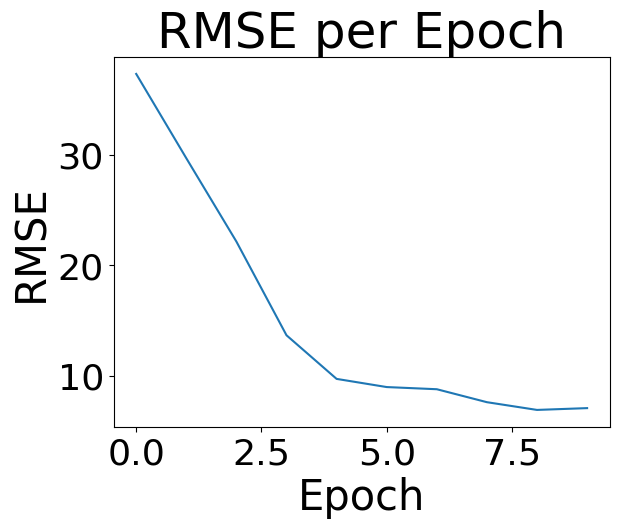

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Custom callback for computing RMSE at each epoch
class RMSECallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data

    def on_train_begin(self, logs=None):
        self.rmse_per_epoch = []

    def on_epoch_end(self, epoch, logs=None):
        x_val, y_val = self.validation_data
        predictions = self.model.predict(x_val)
        rmse = np.sqrt(mean_squared_error(y_val, predictions))
        self.rmse_per_epoch.append(rmse)
        print(f'Epoch {epoch+1}, val_RMSE: {rmse}')

# Assuming feature_data and labeled_output are defined and properly formatted
Nelements = 4 * 3  # Number of sensor elements
L = 2  # Number of multipath components
feature_data_reshaped = feature_data.reshape(-1, Nelements, L + 3, 1)

# Split and normalize data
x_train, x_test, y_train, y_test = train_test_split(feature_data_reshaped, labeled_output, test_size=0.3, random_state=42)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train.reshape(-1, Nelements * (L + 3))).reshape(x_train.shape)
x_test = scaler.transform(x_test.reshape(-1, Nelements * (L + 3))).reshape(x_test.shape)

# Model definition
model = Sequential([
    Conv2D(32, (2, 2), activation='relu', input_shape=(Nelements, L + 3, 1)),
    Conv2D(64, (2, 2), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(2)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with RMSE logging
rmse_callback = RMSECallback(validation_data=(x_test, y_test))
model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test), callbacks=[rmse_callback])

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'RMSE: {rmse}')

# Plotting RMSE
plt.plot(rmse_callback.rmse_per_epoch)
plt.title('RMSE per Epoch')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.show()


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Epoch 1, val_RMSE: 38.17168633779544, val_R^2: -0.03556040870327393
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 3481.2061 - val_loss: 1457.0776
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 2, val_RMSE: 29.171981341569932, val_R^2: 0.3970837114976276
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1316.0184 - val_loss: 851.0045
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 3, val_RMSE: 20.274572821146652, val_R^2: 0.7118746892147846
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 933.7783 - val_loss: 411.0583
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 4, val_RMSE: 14.761428866438537, val_R^2: 0.8466421648646476
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 610.4265 - val_loss: 217.8998
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 5, val_RMSE: 10.743980224159275, val_R^2: 0.9183438349505662
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 422.5811 - val_loss: 115.4331
Epoch 6/10
10/10 ━━━━━━━━━━━

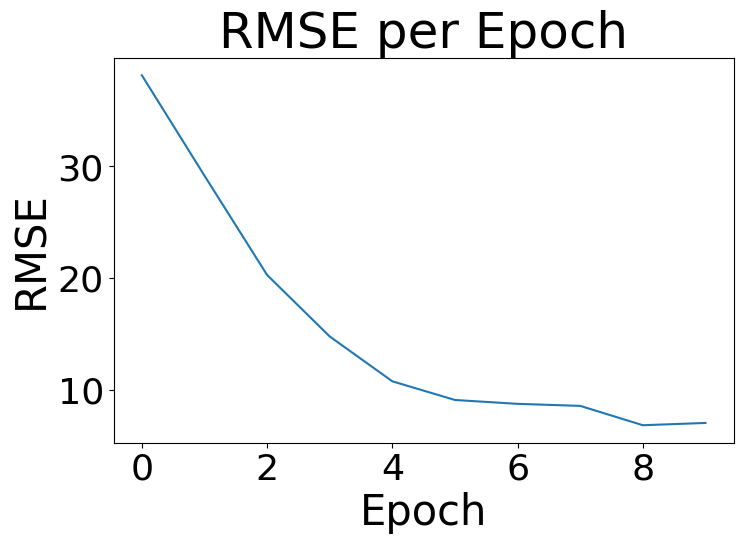

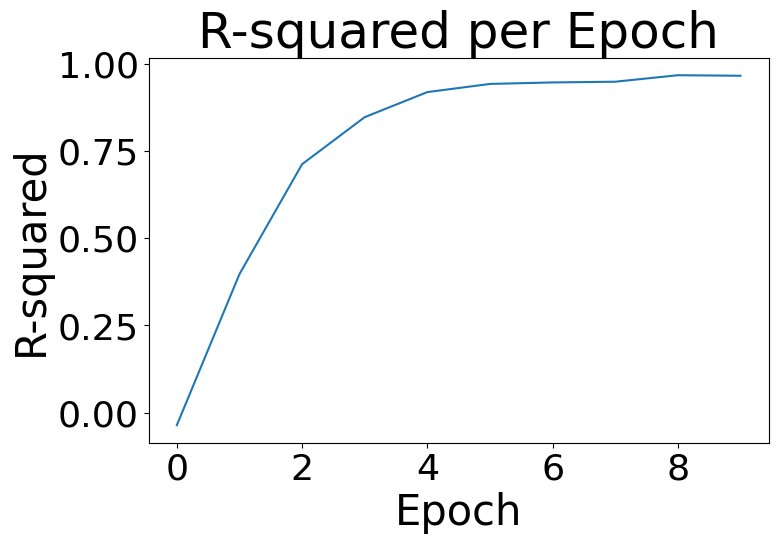

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Custom callback for computing RMSE and R-squared at each epoch
class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data
        self.rmse_per_epoch = []
        self.r2_per_epoch = []

    def on_train_begin(self, logs=None):
        pass

    def on_epoch_end(self, epoch, logs=None):
        x_val, y_val = self.validation_data
        predictions = self.model.predict(x_val)
        rmse = np.sqrt(mean_squared_error(y_val, predictions))
        r_squared = r2_score(y_val, predictions)
        self.rmse_per_epoch.append(rmse)
        self.r2_per_epoch.append(r_squared)
        print(f'Epoch {epoch+1}, val_RMSE: {rmse}, val_R^2: {r_squared}')

# Assuming feature_data and labeled_output are defined and properly formatted
Nelements = 4 * 3  # Number of sensor elements
L = 2  # Number of multipath components
feature_data_reshaped = feature_data.reshape(-1, Nelements, L + 3, 1)

# Split and normalize data
x_train, x_test, y_train, y_test = train_test_split(feature_data_reshaped, labeled_output, test_size=0.3, random_state=42)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train.reshape(-1, Nelements * (L + 3))).reshape(x_train.shape)
x_test = scaler.transform(x_test.reshape(-1, Nelements * (L + 3))).reshape(x_test.shape)

# Model definition
model = Sequential([
    Conv2D(32, (2, 2), activation='relu', input_shape=(Nelements, L + 3, 1)),
    Conv2D(64, (2, 2), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(2)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with metrics logging
metrics_callback = MetricsCallback(validation_data=(x_test, y_test))
model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test), callbacks=[metrics_callback])

# Plotting RMSE and R-squared
plt.figure(figsize=(8, 5))
plt.plot(metrics_callback.rmse_per_epoch)
plt.title('RMSE per Epoch')
plt.xlabel('Epoch')
plt.ylabel('RMSE')

plt.figure(figsize=(8, 5))
plt.plot(metrics_callback.r2_per_epoch)
plt.title('R-squared per Epoch')
plt.xlabel('Epoch')
plt.ylabel('R-squared')
plt.show()


In [ ]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 11, 4, 32)           │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 10, 3, 64)           │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 1920)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │         122,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 394,472 (1.50 MB)

 Trainable params: 131,490 (513.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 262,982 (1.00 MB)

In [ ]:
input_shape = model.input_shape
print(f"Model input shape: {input_shape}")

Model input shape: (None, 12, 5, 1)
